<img src="./img/logo.png" align="right" width="50%"></img>
# iAtlantic GeoNode Workshop
### Tier 2: How to use OGC webservices offered by the iAtlantic GeoNode in your data analysis

## 3. Subset & download data using OGC Web Feature and Coverage Services (WFS/WCS)

The OWSLib library is a python library that makes accessing data and metadata through OGC services possible. The library abstracts all of the traditional HTTP API calls into programmatic function calls. We will be using this library throughout the tutorial to interact with the iAtlantic GeoNode OGC services.

The library is available from GitHub @  https://github.com/geopython/OWSLib

In [1]:
from owslib.wfs import WebFeatureService
from owslib.wcs import WebCoverageService

### 3.1 Get vector data with WFS

#### Create a WebFeatureService (WFS) object
Note that we use version 1.1.0 as in OWSLib this version has support for [OGC Filter Encoding](https://www.ogc.org/standards/filter)

In [2]:
wfs = WebFeatureService('https://www.geonode.iatlantic.eu/geoserver/ows', version = '1.1.0')

#### Find out what the WFS has to offer. Service metadata:

In [3]:
print(wfs.identification.type)
print(wfs.identification.version)
print(wfs.identification.title)
print(wfs.identification.abstract)

WFS
1.1.0
iAtlantic WFS
This WFS service offers vector data collected within the within the framework of the iAtlantic project.


#### See available methods

In [4]:
[operation.name for operation in wfs.operations]

['GetCapabilities',
 'DescribeFeatureType',
 'GetFeature',
 'GetGmlObject',
 'LockFeature',
 'GetFeatureWithLock',
 'Transaction']

#### Get available formats

In [5]:
wfs.getOperationByName('GetFeature').parameters

{'resultType': {'values': ['results', 'hits']},
 'outputFormat': {'values': ['text/xml; subtype=gml/3.1.1',
   'GML2',
   'KML',
   'SHAPE-ZIP',
   'application/gml+xml; version=3.2',
   'application/json',
   'application/vnd.google-earth.kml xml',
   'application/vnd.google-earth.kml+xml',
   'csv',
   'excel',
   'excel2007',
   'gml3',
   'gml32',
   'json',
   'text/xml; subtype=gml/2.1.2',
   'text/xml; subtype=gml/3.2']}}

#### Find out what vector datasets (FeatureTypes) are available
Note that only vector datasets that are uploaded to the GeoNode and are publicly available are shown

In [6]:
list(wfs.contents)

['geonode:iAtlantic_Research_Areas_merged']

#### Get the FeatureType metadata:

In [7]:
print(wfs.contents['geonode:iAtlantic_Research_Areas_merged'].title)
print(wfs.contents['geonode:iAtlantic_Research_Areas_merged'].abstract)

iAtlantic Research Areas
iAtlantic targets 12 large marine regions in the deep sea and open-ocean, chosen because they are: directly impacted by major circulation pathways, in proximity to ocean arrays for monitoring, of international conservation significance (e.g., to the CBD EBSA process) and of interest to Blue Economy and Blue Growth sectors. iAtlantic will assess ecosystem status and work directly with these sectors to provide the data and tools needed for sustainable management. These regions and ecosystems span the Arctic to Southern Ocean: (1) subpolar Mid-Atlantic Ridge open-ocean ecosystem off Iceland; (2) abyssal plain and deep-sea coral banks from the Rockall Trough to the Porcupine Abyssal Plain (PAP); (3) deep-sea coral and hydrothermal vent ecosystems of the central Mid-Atlantic Ridge; (4) deep-sea canyons and open-ocean ecosystem in the northwest Atlantic; (5) subtropical open-ocean ecosystem of the Sargasso Sea; (6) the tropical open-ocean off equatorial Africa; (7) e

#### Get the FeatureType’s schema via `DescribeFeatureType`.
The dictionary returned is compatible with a [Fiona schema object](https://fiona.readthedocs.io/en/latest/fiona.html#fiona.collection.Collection.schema).

In [8]:
wfs.get_schema('geonode:iAtlantic_Research_Areas_merged')

{'properties': {'fid': 'int', 'Id': 'int', 'sa': 'long'},
 'required': ['fid'],
 'geometry': '3D MultiPolygon',
 'geometry_column': 'the_geom'}

#### Subset data with a bounding box

In [9]:
# subset data with a bounding box
response = wfs.getfeature(typename='geonode:iAtlantic_Research_Areas_merged',
                          bbox=(-70,-60,20,0), #subset to the south atlantic
                          outputFormat='application/json')
# write it to a GeoJson file
with open('data/study_areas.json', 'wb') as outfile:
    outfile.write(response.read())
response.close()
# read the GeoJson file using GeoPandas
import geopandas as gpd
gdf = gpd.read_file('data/study_areas.json')
gdf

,id,fid,Id,sa,geometry
0,iAtlantic_Research_Areas_merged.1,1,0,8,"MULTIPOLYGON (((5.00000 -4.50000, 10.00000 -4...."
1,iAtlantic_Research_Areas_merged.8,8,0,7,"MULTIPOLYGON (((-23.28960 1.79618, -21.54000 2..."
2,iAtlantic_Research_Areas_merged.9,9,0,9,"MULTIPOLYGON (((11.62075 -19.72093, 12.91688 -..."
3,iAtlantic_Research_Areas_merged.10,10,0,10,"MULTIPOLYGON (((-39.83194 -20.69933, -37.20178..."
4,iAtlantic_Research_Areas_merged.11,11,0,11,"MULTIPOLYGON (((-38.55458 -20.46184, -38.28848..."
5,iAtlantic_Research_Areas_merged.12,12,0,12,"MULTIPOLYGON (((-56.68701 -38.05359, -55.46951..."


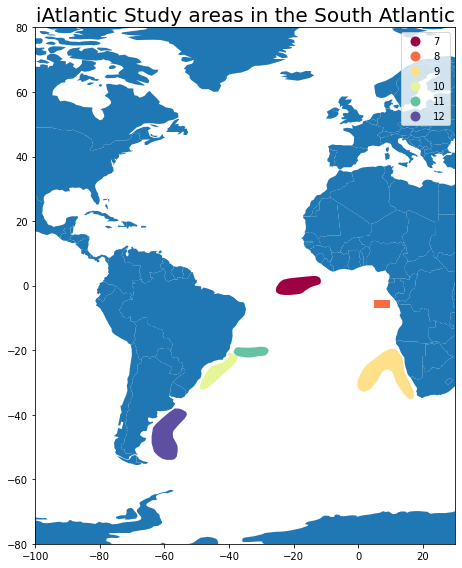

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
# get shapefile of world outline
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(1, figsize=(9,8))
world.plot(ax=ax) # add world base layer
gdf.plot(column='sa',
         categorical=True,
         cmap='Spectral',
         legend=True,
         ax=ax) # add study areas colord by study region number
ax.set_title('iAtlantic Study areas in the South Atlantic',fontsize=20)
ax.set_xlim(-100,30)
ax.set_ylim(-80,80)
plt.tight_layout()

#### Subset data by attributes using [OGC Filter Encoding](https://www.ogc.org/standards/filter)

In [11]:
import owslib.fes as fes #Filter encodin standard
from owslib.etree import etree
# build a filter
sa_filter = fes.PropertyIsEqualTo(propertyname='sa', literal='1') #filter to study area 1
fid_filter = fes.PropertyIsBetween(propertyname='fid', lower = 0, upper= 4) # filter to fid between 0 and 4
filter = fes.Or([sa_filter,fid_filter]) # combine using or
# get an xml representation of the filter
filterxml = etree.tostring(filter.toXML()).decode("utf-8")
# pass it to getFeature
response = wfs.getfeature(typename='geonode:iAtlantic_Research_Areas_merged',outputFormat='application/json',filter=filterxml)
# write it to a GeoJson file
with open('data/study_areas.json', 'wb') as outfile:
    outfile.write(response.read())
response.close()
# read the GeoJson file using GeoPandas
gdf = gpd.read_file('data/study_areas.json')
gdf

,id,fid,Id,sa,geometry
0,iAtlantic_Research_Areas_merged.1,1,0,8,"MULTIPOLYGON (((5.00000 -4.50000, 10.00000 -4...."
1,iAtlantic_Research_Areas_merged.2,2,0,1,"MULTIPOLYGON (((-20.55172 69.48363, -18.87755 ..."
2,iAtlantic_Research_Areas_merged.3,3,0,2,"MULTIPOLYGON (((-13.01780 59.94755, -11.81203 ..."
3,iAtlantic_Research_Areas_merged.4,4,0,3,"MULTIPOLYGON (((-26.68523 42.27528, -25.50542 ..."


### 3.2 Get raster data with WCS

#### <i>Create a WebCoverageService (WCS) object</i>

In [12]:
wcs = WebCoverageService('https://www.geonode.iatlantic.eu/geoserver/ows', version = '1.0.0')

#### <i>Get a list of available coverages</i>

In [13]:
for coverage_name in wcs.contents.keys():
    print(coverage_name)

geonode:a__2018_st_All_avg


#### <i>Retrieve a list of available properties of a coverage</i>

In [14]:
for item in dir(wcs.contents['geonode:a__2018_st_All_avg']):
    if "_" not in item:
        print(item)

abstract
axisDescriptions
boundingBox
boundingBoxWGS84
boundingboxes
crsOptions
defaulttimeposition
grid
id
keywords
styles
supportedCRS
supportedFormats
timelimits
timepositions
title


#### <i>Retrieve grid property information</i>

In [15]:
for item in dir(wcs.contents['geonode:a__2018_st_All_avg'].grid):
    if "_" not in item:
        print(item + ": " + str(wcs.contents['geonode:a__2018_st_All_avg'].grid.__dict__[item]))

axislabels: ['X', 'Y']
dimension: 2
highlimits: ['7507', '6430']
lowlimits: ['0', '0']
offsetvectors: [['1000.0', '0.0'], ['0.0', '-1000.0']]
origin: ['-622500.0', '7034500.0']


#### Get geo-bounding boxes and native CRS

In [16]:
wcs.contents['geonode:a__2018_st_All_avg'].boundingboxes

[{'nativeSrs': 'EPSG:3035',
  'bbox': (-623000.0, 604000.0, 6885000.0, 7035000.0)}]

#### Retrieve supported formats

In [17]:
wcs.contents['geonode:a__2018_st_All_avg'].supportedFormats

['ArcGrid',
 'GeoTIFF',
 'GIF',
 'GeoPackage (mosaic)',
 'ImageMosaic',
 'JPEG',
 'PNG',
 'TIFF']

#### Subset and download raster data using a GetCoverage request

In [18]:
# get parameters for grid
bbox = gdf[gdf.sa == 2].bounds.values[0].tolist() # get bbox for iAtlantic study area 2
crs = gdf.crs.srs # get crs of the Study Area file

In [19]:
# GetCoverage request
response = wcs.getCoverage(identifier='geonode:a__2018_st_All_avg',
                           format='GeoTIFF',
                           bbox=bbox,
                           crs=crs,
                           resx=0.00833333,resy=0.00833333,
                           interpolation='nearest neighbor')
print(response.geturl())
with open('data/vessel_density.tif','wb') as outfile:
    outfile.write(response.read())

http://www.geonode.iatlantic.eu/geoserver/wcs?version=1.0.0&request=GetCoverage&service=WCS&Coverage=geonode%3Aa__2018_st_All_avg&BBox=-20.69131479%2C46.85633841%2C-5.71059932%2C60.37745518&crs=epsg%3A4326&format=GeoTIFF&resx=0.00833333&resy=0.00833333&interpolation=nearest+neighbor


#### Open rasterdata in an xarray object using the rasterio library

In [20]:
import rioxarray
rds = rioxarray.open_rasterio('data/vessel_density.tif')
rds

<xarray.DataArray (band: 1, y: 2249, x: 3473)>
[7810777 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * y            (y) float64 62.7 62.69 62.69 62.68 ... 43.99 43.98 43.98 43.97
  * x            (x) float64 -30.39 -30.38 -30.37 -30.36 ... -1.466 -1.458 -1.45
    spatial_ref  int32 0
Attributes:
    transform:     (0.008334570404300499, 0.0, -30.391519169661805, 0.0, -0.0...
    _FillValue:    -3.4028234663852886e+38
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

#### Plot a map of the rasterdata overlaid with 

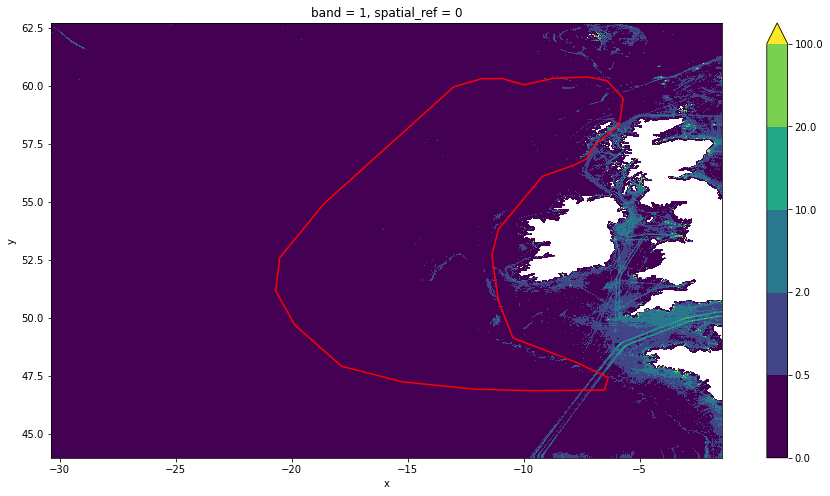

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
# mask with the nodata value
masked_rds = rds.where(rds != rds._FillValue)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
masked_rds.plot(ax = ax, levels = [0,0.5,2,10,20,100]) # plot raster data
gdf[gdf.sa == 2].boundary.plot(ax=ax, color=None, edgecolor = 'red') # plot study areas

### [>> Next: Use OGC services from common GIS software](./4_OGC_services_from_common_GIS_software.ipynb)

<hr>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img style="float: right" alt="Creative Commons Lizenzvertrag" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>